# Fitness Factors Analysis

Which factors influence HRV and RHR improvement?

In [1]:
# Setup 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statistics import stdev

pd.options.display.max_rows = 6000
pd.options.display.max_columns = 6000

# Read Data and Create Data Frames
#df_activs_plus = pd.read_csv('./df_activs_plus.csv')

# warnings supression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Downloading the data from the database

#### Creating a connection to the database

In [2]:
# SQAlchemy
import pandas as pd
from sqlalchemy import create_engine, types
from sqlalchemy import text # to be able to pass string
from sqlalchemy.exc import SQLAlchemyError
from dotenv import dotenv_values # to load the data from .env file

#load the data from .env file
config = dotenv_values()

# define variables for the login
pg_user = config['AZURE_USER'] 
pg_host = config['AZURE_HOST']
pg_port = config['AZURE_PORT']
pg_db = config['AZURE_DB']
pg_schema = config['AZURE_SCHEMA']
pg_pass = config['AZURE_PASS']

# building the URL
url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

#creating the engine

engine = create_engine(url, echo=False)
engine.url

#testing the connection
def test_db_connection(engine):
    try:
        connection = engine.connect() # including 'connection' as variable to close the connection
        print("Connection successful!")
        connection.close() # closing the connection
        return True
    except SQLAlchemyError as e:
        print(f"Connection failed: {e}")
        return False

test_db_connection(engine)

# building the search path
my_schema = pg_schema 

with engine.begin() as conn: 
    result = conn.execute(text(f'SET search_path TO {my_schema};'))

Connection successful!


#### Reading in the data from the database

In [3]:
# reading table into a dataframe

df_activs_plus = pd.read_sql(sql=text('SELECT * FROM public.df_activs_plus;'), con=engine)

df_phys = pd.read_sql(sql=text('SELECT * FROM public.df_phys;'), con=engine)


## Preparation

#### 1a) Preparing `df_activs_m` 

In [4]:
#Creating new and condensed dataframe from df_activs_plus
df_acts = df_activs_plus.drop([
       #'activity id', 'date', 'activity date', 'sport', 'activity type',
       'start time', 
       #'moving time', 
       'elapsed time', 'finish time', 'swim pace','bike pace', 'run pace', 
       #'distance', 
        'avg heart rate','avg heart rate zone', 'max heart rate', 'max heart rate yearly',
        'avg speed', 'max speed', 'avg elapsed speed', 'relative effort',
       'calories', 'pool length', 'elevation gain', 'elevation loss',
       'elevation low', 'elevation high', 'max grade', 'avg grade',
       'avg watts', 'avg cadence', 'max cadence', 'activity name',
       'activity description', 'perceived exertion', 'event',
       'injury description', 'filename', 'filenumber', 
       'below zones','no hr collected', 'z1', 'z2', 'z3', 'z4', 'z5', 
       #'time low zones','time high zones', 'training mode', 
       'dist below zones','dist no hr collected', 'dist z1', 'dist z2', 'dist z3', 'dist z4','dist z5', 
       'cycle id', 'wake onset', 'to bed date', 'sleep onset',
       'sleep performance', 'recovery score', 'day strain', 
       #'rhr', 'hrv',
       'respiratory rate', 'asleep duration', 'in bed duration',
       'light sleep duration', 'deep sleep duration', 'rem sleep duration',
       'awake duration', 'sleep need', 'sleep debt', 'sleep efficiency',
       'sleep consistency', 'skin temp', 'blood oxygen', 'cal burned',
       'max hr', 'avg hr', 'cycle start time', 'cycle end time',
       'cycle timezone'
], axis=1)

# sorting the dataframe by start of the activity
df_acts.sort_values(by=['activity date'], inplace=True)

# Change data types
df_acts["date"] = pd.to_datetime(df_acts["date"], format="mixed",  dayfirst = True)
df_acts["activity date"] = pd.to_datetime(df_acts["activity date"], format="mixed",  dayfirst = True)
df_acts["moving time"]= pd.to_timedelta(df_acts["moving time"])


# Since I want to compare months' with each other, I create a month column
df_acts['month'] = df_acts['date'].dt.to_period('M') 
#df_acts['week'] = df_acts['date'].dt.to_
#('W') 


In [5]:
# I also want the count of activities per month
#df_acts['activity count'] = df_acts.groupby('month')['date'].transform('count')
df_acts['activity count'] = 1

In [6]:
# Rearranging columns
df_acts = df_acts[[ 'activity id', 'date','month', #'week', 
        'activity date', 'sport', 'activity type',
       'moving time', 'distance',  "activity count", 'time low zones', 'time high zones',
       'training mode', 'rhr', 'hrv', 
 ]]

# dropping even more columns
df_acts = df_acts.drop([
       'activity id', 'date', 'activity date', 'sport', 'activity type', "time low zones","time high zones", "training mode", "rhr", "hrv"
       ], axis=1)

In [7]:
# Grouping by month
df_activs_m = df_acts.groupby('month').sum().reset_index()

In [8]:
# the activity dataframe and the physical dataframe are over different timeperiods. To align them, I drop rows outside the timeperiod here
df_activs_m = df_activs_m.drop(df_activs_m[df_activs_m["month"]< "2021-01"].index)
df_activs_m = df_activs_m.drop(df_activs_m[df_activs_m["month"]> "2024-12"].index)

In [9]:
#rounding columns
df_activs_m["distance"] = df_activs_m["distance"].astype(int)

#### 1b) Preparing `df_phys_m` 

In [10]:
#Creating new and condensed dataframe
df_phys_m = df_phys.drop([
       'cycle id', 
       #'date', 
       'wake onset', 'to bed date', 'sleep onset',
       'sleep performance', 'recovery score', 'day strain', 
       #'rhr', 'hrv',
       'respiratory rate', 'asleep duration', 'in bed duration',
       'light sleep duration', 'deep sleep duration', 'rem sleep duration',
       'awake duration', 'sleep need', 'sleep debt', 'sleep efficiency',
       'sleep consistency', 'skin temp', 'blood oxygen', 'cal burned',
       'max hr', 'avg hr', 'cycle start time', 'cycle end time',
       'cycle timezone'
], axis=1)

# sorting the dataframe by date
df_phys_m.sort_values(by=['date'], inplace=True)

# Change data types
df_phys_m["date"] = pd.to_datetime(df_phys_m["date"], format="mixed",  dayfirst = True)

# Since I want to compare months' with each other, I create a month column
df_phys_m['month'] = df_phys_m['date'].dt.to_period('M') 

In [11]:
# Rearranging columns
df_phys_m = df_phys_m[[ 'date','month', 'rhr', 'hrv']]

# dropping even more columns
df_phys_m = df_phys_m.drop(['date'], axis=1)

In [12]:
#Creating new columns with monthly averages
df_phys_m['rhr per month'] = df_phys_m.groupby('month')['rhr'].transform('mean')
df_phys_m['hrv per month'] = df_phys_m.groupby('month')['hrv'].transform('mean')

# dropping the not anymore needed columns
df_phys_m = df_phys_m.drop(['rhr', 'hrv'], axis=1)

In [13]:
# Grouping by month
df_phys_m = df_phys_m.groupby('month').mean().reset_index()

In [14]:
# the activity dataframe and the physical dataframe are over different timeperiods. To align them, I drop rows outside the timeperiod here
df_phys_m = df_phys_m.drop(df_phys_m[df_phys_m["month"] < "2021-01"].index)


In [15]:
#rounding columns
df_phys_m["hrv per month"] = df_phys_m["hrv per month"].round(2)
df_phys_m["rhr per month"] = df_phys_m["rhr per month"].round(2)

#### 2) Joining `df_activs_m` and `df_phys_m` 

In [16]:
df_months = pd.merge(df_activs_m,df_phys_m, on="month", how="inner" )

In [17]:
# final renaming of columns
df_months = df_months.rename({"rhr per month": "rhr"}, axis=1)
df_months = df_months.rename({"hrv per month": "hrv"}, axis=1)
df_months = df_months.rename({"activity count": "activities"}, axis=1)
df_months = df_months.rename({"moving time": "train time"}, axis=1)

In [18]:
# aggregate new columns 
#df_months["moving time mins"] = df_months["moving time"].dt.minute

# Convert timedelta to total minutes
df_months['train time'] = (df_months["train time"].dt.total_seconds() /60).astype(int)

## Analysis

### 1) General Correlations

In [19]:
# Correlations with RHR
corr_rhr_distance = df_months['distance'].corr(df_months['rhr']).round(2)
corr_rhr_time = df_months['train time'].corr(df_months['rhr']).round(2)
corr_rhr_activities = df_months['activities'].corr(df_months['rhr']).round(2)

# Correlations with HRV
corr_hrv_distance = df_months['distance'].corr(df_months['hrv']).round(2)
corr_hrv_time = df_months['train time'].corr(df_months['hrv']).round(2)
corr_hrv_activities = df_months['activities'].corr(df_months['hrv']).round(2)

print ("---RHR---")
print(f"correlation between monthly distance and RHR: {corr_rhr_distance}")
print(f"correlation between monthly training time and RHR: {corr_rhr_time}")
print(f"correlation between monthly number of activities and RHR: {corr_rhr_activities}")

print ("---HRV---")
print(f"correlation between monthly distance and HRV: {corr_hrv_distance}")
print(f"correlation between monthly training time and HRV: {corr_hrv_time}")
print(f"correlation between monthly number of activities and RHR: {corr_hrv_activities}")

---RHR---
correlation between monthly distance and RHR: -0.22
correlation between monthly training time and RHR: -0.11
correlation between monthly number of activities and RHR: -0.51
---HRV---
correlation between monthly distance and HRV: 0.26
correlation between monthly training time and HRV: 0.2
correlation between monthly number of activities and RHR: 0.51


#### Training Hours & Fitness

correlation between monthly training time and HRV: 0.2
Spearman correlation: 0.3064564280445762, p-value: 0.03413336082443809


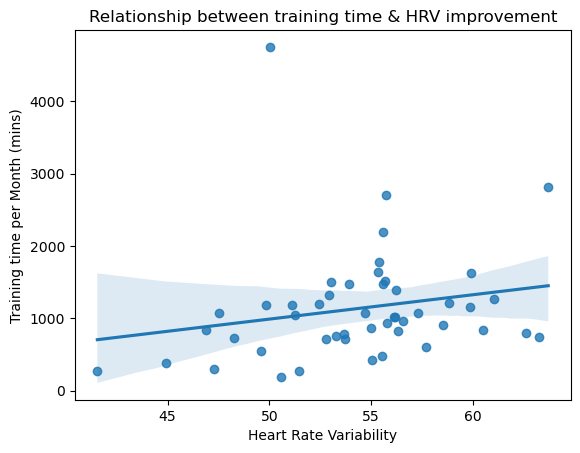

In [20]:
print(f"correlation between monthly training time and HRV: {corr_hrv_time}")
sns.regplot(data=df_months, x="hrv", y="train time")

plt.xlabel('Heart Rate Variability')
plt.ylabel('Training time per Month (mins)')
plt.title("Relationship between training time & HRV improvement");

# Significance
from scipy.stats import spearmanr
corr, p_value = spearmanr(df_months['train time'], df_months['hrv'])
print(f"Spearman correlation: {corr}, p-value: {p_value}")

correlation between monthly training time and RHR: -0.11
Spearman correlation: -0.2965094225304394, p-value: 0.04071705061900299


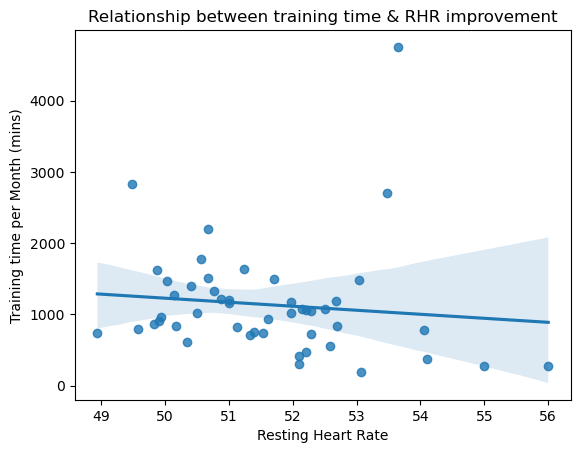

In [21]:
print(f"correlation between monthly training time and RHR: {corr_rhr_time}")
sns.regplot(data=df_months, x="rhr", y="train time")

plt.xlabel('Resting Heart Rate')
plt.ylabel('Training time per Month (mins)')
plt.title("Relationship between training time & RHR improvement");

# Significance
from scipy.stats import spearmanr
corr, p_value = spearmanr(df_months['train time'], df_months['rhr'])
print(f"Spearman correlation: {corr}, p-value: {p_value}")

#### Distance & Fitness

correlation between monthly distance and HRV: 0.26
Spearman correlation: 0.24871760085154532, p-value: 0.08826042281696445


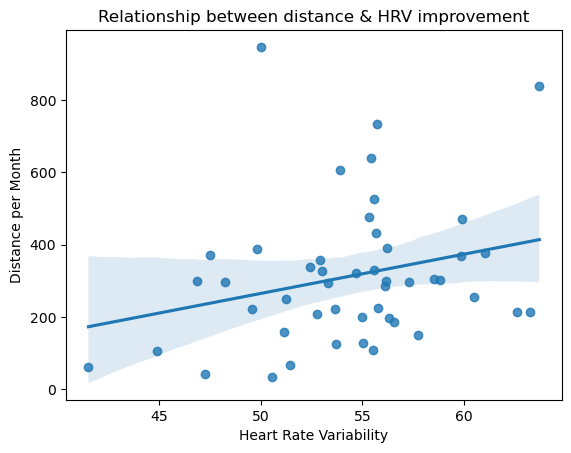

In [22]:
print(f"correlation between monthly distance and HRV: {corr_hrv_distance}")
sns.regplot(data=df_months, x="hrv", y="distance")

#plt.legend()
plt.xlabel('Heart Rate Variability')
plt.ylabel('Distance per Month')
plt.title("Relationship between distance & HRV improvement");

# Significance
from scipy.stats import spearmanr
corr, p_value = spearmanr(df_months['distance'], df_months['hrv'])
print(f"Spearman correlation: {corr}, p-value: {p_value}")

correlation between monthly distance and RHR: -0.22
Spearman correlation: -0.26859392123579223, p-value: 0.06490630992657717


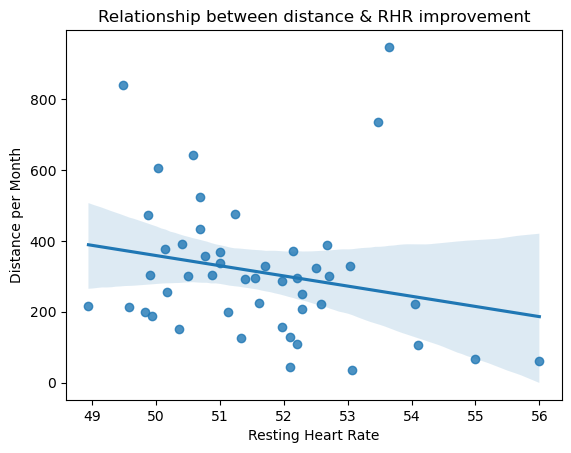

In [23]:
print(f"correlation between monthly distance and RHR: {corr_rhr_distance}")
sns.regplot(data=df_months, x="rhr", y="distance")

#plt.legend()
plt.xlabel('Resting Heart Rate')
plt.ylabel('Distance per Month')
plt.title("Relationship between distance & RHR improvement");

# Significance
from scipy.stats import spearmanr
corr, p_value = spearmanr(df_months['distance'], df_months['rhr'])
print(f"Spearman correlation: {corr}, p-value: {p_value}")

#### Number of Activities & Fitness

correlation between monthly number of activities and HRV: 0.51
Spearman correlation: 0.45894203735441985, p-value: 0.001034645923440727


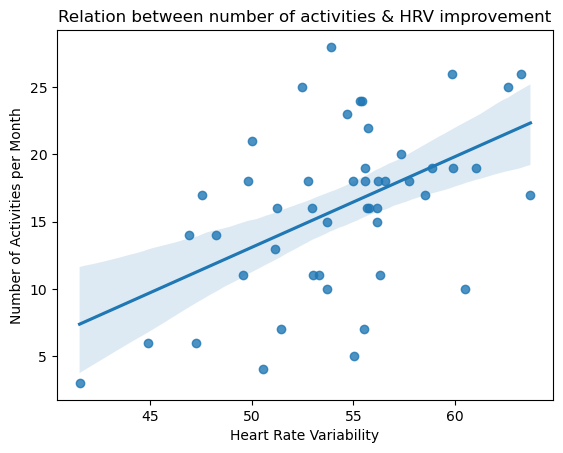

In [24]:
print(f"correlation between monthly number of activities and HRV: {corr_hrv_activities}")
sns.regplot(data=df_months, x="hrv", y="activities")

#plt.legend()
plt.xlabel('Heart Rate Variability')
plt.ylabel('Number of Activities per Month')
plt.title("Relation between number of activities & HRV improvement");

# Significance
from scipy.stats import spearmanr
corr, p_value = spearmanr(df_months['activities'], df_months['hrv'])
print(f"Spearman correlation: {corr}, p-value: {p_value}")

correlation between monthly number of activities and RHR: -0.51
Spearman correlation: -0.4263913644726431, p-value: 0.002511403862754945


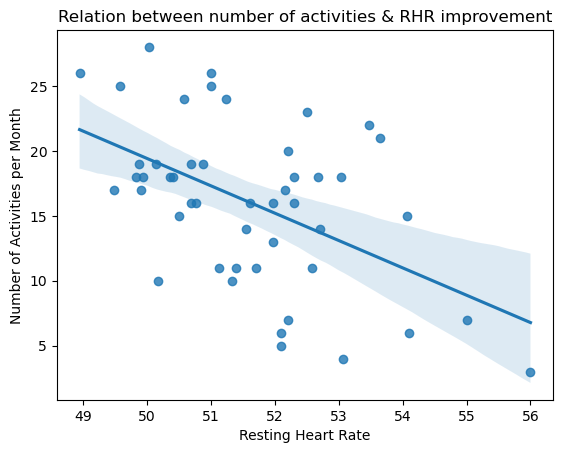

In [25]:
print(f"correlation between monthly number of activities and RHR: {corr_rhr_activities}")
sns.regplot(data=df_months, x="rhr", y="activities")

#plt.legend()
plt.xlabel('Resting Heart Rate')
plt.ylabel('Number of Activities per Month')
plt.title("Relation between number of activities & RHR improvement");

# Significance
from scipy.stats import spearmanr
corr, p_value = spearmanr(df_months['activities'], df_months['rhr'])
print(f"Spearman correlation: {corr}, p-value: {p_value}")

### 2) How DISTANCE CHANGE influences HRV & RHR

#### 1.1) Overall `SD` in distance for each discipline

In [26]:
# creating subsets per discipline
df_swims =  df_activs_plus [df_activs_plus["sport"] == "Swim"]
df_bikes =  df_activs_plus [df_activs_plus["sport"] == "Bike"]
df_runs =  df_activs_plus [df_activs_plus["sport"] == "Run"]

# sorting by date
df_swims.sort_values(by=['activity date'], inplace=True)
df_bikes.sort_values(by=['activity date'], inplace=True)
df_runs.sort_values(by=['activity date'], inplace=True)
df_activs_plus.sort_values(by=['activity date'], inplace=True)


# dropping null values in the distance column
df_swims = df_swims.dropna(subset=["distance"])

/var/folders/1m/_v4c_fx94fv55ggvl5l850080000gn/T/ipykernel_28719/1582662391.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_swims.sort_values(by=['activity date'], inplace=True)
/var/folders/1m/_v4c_fx94fv55ggvl5l850080000gn/T/ipykernel_28719/1582662391.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bikes.sort_values(by=['activity date'], inplace=True)
/var/folders/1m/_v4c_fx94fv55ggvl5l850080000gn/T/ipykernel_28719/1582662391.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [27]:
# Creating lists for distance per sport to calculate the SD in the next step
swims_dists = df_swims["distance"]
bikes_dists = df_bikes["distance"]
runs_dists = df_runs["distance"]

In [28]:
# Calculating the SD
print(f"The Standard Deviation of all swim workout distances is {round(stdev(swims_dists), 2)} km")
print(f"The Standard Deviation of all bike workout distances is {round(stdev(bikes_dists), 2)} km")
print(f"The Standard Deviation of all run workout distances is {round(stdev(runs_dists), 2)} km")                       

The Standard Deviation of all swim workout distances is 0.86 km
The Standard Deviation of all bike workout distances is 31.62 km
The Standard Deviation of all run workout distances is 4.81 km


#### 1.2) Labeling each months as `consistent` or `inconsistent`

Steps:
1. New column: Compare the distance of each swim/bike/run to the previous 2 swim/bike/run (give change in percent)
2. New column: Label each activity with a change of more than "NORMAL" inconsistent – otherwise consistent 
3. Make dataframe with RHR & HRV per month (rows = month)
4. New column: Percentage of consistent activities per month
6. New column ["consistency"]: if more than 50% of the monthly activities were consistent -> label it "consistent"

##### 1.2.1. Compare the distance of each swim/bike/run to the previous 2 swim/bike/run (give change in percent)


In [29]:

# DISTANCE CHANGE COMPARED WITH ONLY THE LAST ACTIVITY
''' 
# Compare each activity to last and return the change 
df_swims['dist change'] = (df_swims['distance'].pct_change().fillna(1))
df_bikes['dist change'] = (df_bikes['distance'].pct_change().fillna(1))
df_runs['dist change'] = (df_runs['distance'].pct_change().fillna(1))  


# Convert all values to positive (absolute values)
df_swims['dist change'] = df_swims['dist change'].abs()
df_bikes['dist change'] = df_bikes['dist change'].abs()
df_runs['dist change'] = df_runs['dist change'].abs()

''' 

" \n# Compare each activity to last and return the change \ndf_swims['dist change'] = (df_swims['distance'].pct_change().fillna(1))\ndf_bikes['dist change'] = (df_bikes['distance'].pct_change().fillna(1))\ndf_runs['dist change'] = (df_runs['distance'].pct_change().fillna(1))  \n\n\n# Convert all values to positive (absolute values)\ndf_swims['dist change'] = df_swims['dist change'].abs()\ndf_bikes['dist change'] = df_bikes['dist change'].abs()\ndf_runs['dist change'] = df_runs['dist change'].abs()\n\n"

In [30]:
# DISTANCE CHANGE COMPARED WITH THE LAST 2 ACTIVITIES

# CHANGE IN SWIM DISTANCE


# Compare each activities' distance to last 3 exercises and return the change 
df_swims['dist change'] = (df_swims['distance'] / df_swims['distance'].rolling(3).mean() - 1).fillna(1)  
# Convert all values to positive (absolute values)
df_swims['dist change'] = df_swims['dist change'].abs()

# CHANGE IN BIKE DISTANCE

# Compare each activities' distance to last 3 exercises and return the change 
df_bikes['dist change'] = (df_bikes['distance'] / df_bikes['distance'].rolling(3).mean() - 1).fillna(1)  
# Convert all values to positive (absolute values)
df_bikes['dist change'] = df_bikes['dist change'].abs()

# CHANGE IN RUN DISTANCE

# Compare each activities' distance to last 3 exercises and return the change 
df_runs['dist change'] = (df_runs['distance'] / df_runs['distance'].rolling(3).mean() - 1).fillna(1)  
# Convert all values to positive (absolute values)

df_runs['dist change'] = df_runs['dist change'].abs()
'''
''' 

/var/folders/1m/_v4c_fx94fv55ggvl5l850080000gn/T/ipykernel_28719/3595566041.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bikes['dist change'] = (df_bikes['distance'] / df_bikes['distance'].rolling(3).mean() - 1).fillna(1)
/var/folders/1m/_v4c_fx94fv55ggvl5l850080000gn/T/ipykernel_28719/3595566041.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bikes['dist change'] = df_bikes['dist change'].abs()
/var/folders/1m/_v4c_fx94fv55ggvl5l850080000gn/T/ipykernel_28719/3595566041.py:21: SettingWith

'\n'

In [31]:
# Defining what a "normal" change in distance is 

# OPTION 1: Given training literature, a 10 per cent increase is considered good
#swim_norm_dist_change = 10  #per cent
#bike_norm_dist_change = 10  #per cent
#run_norm_dist_change = 10   #per cent

# OPTION 2: Assumption: A normal change that the athlete's body is used to is the average change over the athlete's whole training history. Hence: 
swim_norm_dist_change = round((df_swims['dist change'].mean()*100),1) #per cent
bike_norm_dist_change = round((df_bikes['dist change'].mean()*100),1)
run_norm_dist_change = round((df_runs['dist change'].mean()*100),1)

print(f"On average, the distance of a swimming activity changes by {swim_norm_dist_change} per cent compared to the 2 previous sessions" )
print(f"On average, the distance of a cycling activity changes by {bike_norm_dist_change} per cent compared to the 2 previous sessions" )
print(f"On average, the distance of a running activity changes by {run_norm_dist_change} per cent compared to the 2 previous sessions" )

#print(f"On average, the distance of a cycling activity changes by {round( df_bikes['distance change'].mean()*100, 2)} per cent compared to the 2 previous sessions" )

On average, the distance of a swimming activity changes by 28.9 per cent compared to the 2 previous sessions
On average, the distance of a cycling activity changes by 37.2 per cent compared to the 2 previous sessions
On average, the distance of a running activity changes by 30.2 per cent compared to the 2 previous sessions


#####  1.2.2. Label each activity with a change of more than "NORMAL" inconsistent – otherwise consistent 


In [32]:
#### LABELING SWIMS

# create a list of our conditions
swim_conditions = [
    ((df_swims['dist change']) <= (swim_norm_dist_change/100)),
    ((df_swims['dist change']) > (swim_norm_dist_change/100)),
    ]
# create a list of the values we want to assign for each condition
values = ['1', '0']   ###🔴🔴🔴🔴🔴

# create a new column and use np.select to assign values to it using our lists as arguments
df_swims["swim dist cons"] = np.select(swim_conditions, values)


#### LABELING RIDES

# create a list of our conditions
bike_conditions = [
    ((df_bikes['dist change']) <= (bike_norm_dist_change/100)),
    ((df_bikes['dist change']) > (bike_norm_dist_change/100)),
    ]
# create a list of the values we want to assign for each condition
values = ['1', '0']    ###🔴🔴🔴🔴🔴

# create a new column and use np.select to assign values to it using our lists as arguments
df_bikes["bike dist cons"] = np.select(bike_conditions, values)


#### LABELING RUNS

# create a list of our conditions
run_conditions = [
    ((df_runs['dist change']) <= (run_norm_dist_change/100)),
    ((df_runs['dist change']) > (run_norm_dist_change/100)),
    ]
# create a list of the values we want to assign for each condition
values = ['1', '0']  ###🔴🔴🔴🔴🔴

# create a new column and use np.select to assign values to it using our lists as arguments
df_runs["run dist cons"] = np.select(run_conditions, values)

/var/folders/1m/_v4c_fx94fv55ggvl5l850080000gn/T/ipykernel_28719/2336955629.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bikes["bike dist cons"] = np.select(bike_conditions, values)
/var/folders/1m/_v4c_fx94fv55ggvl5l850080000gn/T/ipykernel_28719/2336955629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runs["run dist cons"] = np.select(run_conditions, values)


#####  1.2.3. Make dataframe with RHR & HRV per month (rows = month)

In [33]:
df_cons = df_phys_m

#####  1.2.4. Percentage of consistent activities per month


In [34]:
# Transforming date to proper type
df_swims['date'] = pd.to_datetime(df_swims['date'])
df_bikes['date'] = pd.to_datetime(df_bikes['date'])
df_runs['date'] = pd.to_datetime(df_runs['date'])

# Transforming dist consistency  to proper type
df_swims['swim dist cons'] = df_swims['swim dist cons'].astype(int)
df_bikes['bike dist cons'] = df_bikes['bike dist cons'].astype(int)
df_runs['run dist cons'] = df_runs['run dist cons'].astype(int)

# Since I want to compare months' with each other, I create a month column
df_swims['month'] = df_swims['date'].dt.to_period('M') 
df_bikes['month'] = df_bikes['date'].dt.to_period('M') 
df_runs['month'] = df_runs['date'].dt.to_period('M') 

# For later merging & grouping the column names have to be consistent 
#df_swims['swim dist change'] = df_swims['dist change']
#df_bikes['bike dist change'] = df_bikes['dist change']
#df_runs['run dist change'] = df_runs['dist change']

/var/folders/1m/_v4c_fx94fv55ggvl5l850080000gn/T/ipykernel_28719/3862236090.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bikes['date'] = pd.to_datetime(df_bikes['date'])
/var/folders/1m/_v4c_fx94fv55ggvl5l850080000gn/T/ipykernel_28719/3862236090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runs['date'] = pd.to_datetime(df_runs['date'])
/var/folders/1m/_v4c_fx94fv55ggvl5l850080000gn/T/ipykernel_28719/3862236090.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [35]:
# Merging activities with the new columns into one combined dataframe (for Katharina)
df_bikes_change = df_bikes[['activity id', 'dist change', 'month' ]]  #'bike dist cons'
df_swims_change = df_swims[['activity id', 'dist change', 'month']]   #'swim dist cons'
df_runs_change = df_runs[['activity id', 'dist change', 'month' ]]   #'run dist cons'

df_activs_change = pd.concat([df_bikes_change, df_swims_change])
df_activs_change = pd.concat([df_activs_change, df_runs_change])

# Saving for database upload for Katharina's Analysis
'''
df_activs_change.to_csv('../data/df_activs_change.csv', index=False)
'''

"\ndf_activs_change.to_csv('../data/df_activs_change.csv', index=False)\n"

In [36]:
# Making the dataframes smaller 
df_swims_cons = df_swims.drop([
    'activity id', 'date', 'activity date', 'sport', 'activity type',
       'start time', 'moving time', 'elapsed time', 'finish time', 'swim pace',
       'bike pace', 'run pace', 'distance', 'avg heart rate',
       'avg heart rate zone', 'max heart rate', 'max heart rate yearly',
       'avg speed', 'max speed', 'avg elapsed speed', 'relative effort',
       'calories', 'pool length', 'elevation gain', 'elevation loss',
       'elevation low', 'elevation high', 'max grade', 'avg grade',
       'avg watts', 'avg cadence', 'max cadence', 'activity name',
       'activity description', 'perceived exertion', 'event',
       'injury description', 'filename', 'filenumber', 'below zones',
       'no hr collected', 'z1', 'z2', 'z3', 'z4', 'z5', 'time low zones',
       'time high zones', 'training mode', 'dist below zones',
       'dist no hr collected', 'dist z1', 'dist z2', 'dist z3', 'dist z4',
       'dist z5', 'cycle id', 'wake onset', 'to bed date', 'sleep onset',
       'sleep performance', 'recovery score', 'day strain', 'rhr', 'hrv',
       'respiratory rate', 'asleep duration', 'in bed duration',
       'light sleep duration', 'deep sleep duration', 'rem sleep duration',
       'awake duration', 'sleep need', 'sleep debt', 'sleep efficiency',
       'sleep consistency', 'skin temp', 'blood oxygen', 'cal burned',
       'max hr', 'avg hr', 'cycle start time', 'cycle end time',
       'cycle timezone' ,'dist change'
       # ,   'month'
], axis=1)

# Making the dataframes smaller 
df_bikes_cons = df_bikes.drop([
    'activity id', 'date', 'activity date', 'sport', 'activity type',
       'start time', 'moving time', 'elapsed time', 'finish time', 'swim pace',
       'bike pace', 'run pace', 'distance', 'avg heart rate',
       'avg heart rate zone', 'max heart rate', 'max heart rate yearly',
       'avg speed', 'max speed', 'avg elapsed speed', 'relative effort',
       'calories', 'pool length', 'elevation gain', 'elevation loss',
       'elevation low', 'elevation high', 'max grade', 'avg grade',
       'avg watts', 'avg cadence', 'max cadence', 'activity name',
       'activity description', 'perceived exertion', 'event',
       'injury description', 'filename', 'filenumber', 'below zones',
       'no hr collected', 'z1', 'z2', 'z3', 'z4', 'z5', 'time low zones',
       'time high zones', 'training mode', 'dist below zones',
       'dist no hr collected', 'dist z1', 'dist z2', 'dist z3', 'dist z4',
       'dist z5', 'cycle id', 'wake onset', 'to bed date', 'sleep onset',
       'sleep performance', 'recovery score', 'day strain', 'rhr', 'hrv',
       'respiratory rate', 'asleep duration', 'in bed duration',
       'light sleep duration', 'deep sleep duration', 'rem sleep duration',
       'awake duration', 'sleep need', 'sleep debt', 'sleep efficiency',
       'sleep consistency', 'skin temp', 'blood oxygen', 'cal burned',
       'max hr', 'avg hr', 'cycle start time', 'cycle end time',
       'cycle timezone' ,'dist change'
       # , 'month'
], axis=1)

# Making the dataframes smaller 
df_runs_cons = df_runs.drop([
    'activity id', 'date', 'activity date', 'sport', 'activity type',
       'start time', 'moving time', 'elapsed time', 'finish time', 'swim pace',
       'bike pace', 'run pace', 'distance', 'avg heart rate',
       'avg heart rate zone', 'max heart rate', 'max heart rate yearly',
       'avg speed', 'max speed', 'avg elapsed speed', 'relative effort',
       'calories', 'pool length', 'elevation gain', 'elevation loss',
       'elevation low', 'elevation high', 'max grade', 'avg grade',
       'avg watts', 'avg cadence', 'max cadence', 'activity name',
       'activity description', 'perceived exertion', 'event',
       'injury description', 'filename', 'filenumber', 'below zones',
       'no hr collected', 'z1', 'z2', 'z3', 'z4', 'z5', 'time low zones',
       'time high zones', 'training mode', 'dist below zones',
       'dist no hr collected', 'dist z1', 'dist z2', 'dist z3', 'dist z4',
       'dist z5', 'cycle id', 'wake onset', 'to bed date', 'sleep onset',
       'sleep performance', 'recovery score', 'day strain', 'rhr', 'hrv',
       'respiratory rate', 'asleep duration', 'in bed duration',
       'light sleep duration', 'deep sleep duration', 'rem sleep duration',
       'awake duration', 'sleep need', 'sleep debt', 'sleep efficiency',
       'sleep consistency', 'skin temp', 'blood oxygen', 'cal burned',
       'max hr', 'avg hr', 'cycle start time', 'cycle end time',
       'cycle timezone' ,'dist change'
       # ,  'month'
], axis=1)


In [37]:
# Grouping by month
df_swims_cons_m = df_swims_cons.groupby('month').mean().reset_index()
df_bikes_cons_m = df_bikes_cons.groupby('month').mean().reset_index()
df_runs_cons_m = df_runs_cons.groupby('month').mean().reset_index()

In [38]:
df_swims_cons_m.tail(10)

,month,moving time seconds,swim dist cons
51,2024-05,2524.000000,1.000000
52,2024-06,1846.800000,0.700000
53,2024-07,1729.666667,0.666667
54,2024-08,1701.400000,0.400000
55,2024-09,1276.800000,0.000000
56,2024-10,3078.500000,0.666667
57,2024-11,2368.600000,1.000000
58,2024-12,2865.200000,1.000000
59,2025-01,3885.000000,1.000000
60,2025-02,3471.000000,1.000000


In [39]:
# Merging all 3 dataframes into 1
df_cons_activs = pd.merge(df_swims_cons_m, df_bikes_cons_m,   on='month', how="outer")
df_cons_activs = pd.merge(df_cons_activs, df_runs_cons_m,   on='month', how="outer")

In [40]:
# Creating one dataframe that holds all 
df_cons = pd.merge(df_cons, df_cons_activs,   on='month', how="inner")#.fillna(0)  #🔴🔴🔴filling null values with  0 because in a month where I didn't do an activity, this is not consistent 

#####  1.2.5. Labeling each month as consistent or not

In [41]:
# Creating an over all distance consistency column over all three disciplines 

#df_cons["all dist cons"] = (df_cons["swim dist cons"] + df_cons["bike dist cons"]  + df_cons["run dist cons"])
df_cons["dist consistency"] = df_cons[["swim dist cons", "bike dist cons", "run dist cons"]].mean(axis=1)

#df_cons["dist change"] = df_cons[["swim dist change", "bike dist change", "run dist change"]].mean(axis=1)

In [42]:
# New column: if more than 50% of the monthly activities were consistent -> label it "consistent"

# create a list of our conditions
conditions = [
    ((df_cons["dist consistency"]) <= 0.5),      # 
    ((df_cons["dist consistency"]) > 0.5),     # 
    ]
# create a list of the values we want to assign for each condition
values = ['inconsistent', 'consistent']        #🔴🔴🔴

# create a new column and use np.select to assign values to it using our lists as arguments
df_cons["consistency"] = np.select(conditions, values)
'''
''' 

'\n'

In [43]:
# rearranging columns
df_cons = df_cons[[ "month", "rhr per month", "hrv per month",  "consistency", "dist consistency", "swim dist cons", "bike dist cons", "run dist cons"
 ]]

#####  1.2.6. Grouping consistent and inconsistent months

In [44]:
df_cons["rhr shifted"] = df_cons["rhr per month"].shift(-1)
df_cons["hrv shifted"] = df_cons["hrv per month"].shift(-1)

In [45]:
# grouping by "consitency"
df_consistencies = df_cons.groupby('consistency').mean().reset_index()
df_consistencies

# rearranging
df_consistencies = df_consistencies.drop([
       'month', 'dist consistency', 'swim dist cons', 'bike dist cons', 'run dist cons', 
       ], axis=1)

# renaming
df_consistencies = df_consistencies.rename({"rhr per month": "RHR during month"}, axis=1)
df_consistencies = df_consistencies.rename({"hrv per month": "HRV during month"}, axis=1)
df_consistencies = df_consistencies.rename({"rhr shifted": "RHR one month later"}, axis=1)
df_consistencies = df_consistencies.rename({"hrv shifted": "HRV one month later"}, axis=1)

In [46]:
df_consistencies

,consistency,RHR during month,HRV during month,RHR one month later,HRV one month later
0,consistent,51.775000,53.103667,51.567931,54.069310
1,inconsistent,51.306667,56.481667,51.737222,54.881667
